In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
keras = tf.keras


2023-03-15 15:43:33.234037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
test = tf.data.Dataset.from_tensor_slices([1, 2, 3])

2023-03-15 15:43:37.902231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:


import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [4]:
Q_MEAN = 0.5
EPOCH = 2
POPULATION_SIZE = 10000
TRAIN_DIM = 100
STEP = 1

In [5]:

import numpy as np

def initialize_with_str_seed(init_str):
    """
    Initializes random number generator with seed corresponding to given input string init_str.
    :param init_str: Initialization string according to which seed will be computed. Seed is the sum of the ASCII
                     values of each character in init_str.
    """
    rnd_val = 0
    if init_str:
        for c in init_str:
            rnd_val += ord(c)
    np.random.seed(rnd_val)

def gen_data(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y

def gen_valid(n, d, seed = None):
    if seed:
        initialize_with_str_seed(seed)
    
    n = int(n/10)
    
    p = (1.0 + np.sqrt(max(2 * Q_MEAN - 1, 1 - 2 * Q_MEAN))) / 2 
    data = np.random.choice([-1, 1], (n, d), p=[1 -p, p])
    data_y = np.random.choice([0, 1], n, p=[1 -p, p])
    return data, data_y



In [6]:
import math

x_train, y_train = gen_data(POPULATION_SIZE, TRAIN_DIM)
x_valid, y_valid = gen_data(int(POPULATION_SIZE/500), TRAIN_DIM)


In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [8]:

def compile_and_fit_model(model, train_set, epoch_num = EPOCH, eager = False):

    
    lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"],
                run_eagerly = eager)

    history = model.fit(train_set, epochs = epoch_num, callbacks=[lr_schedule])
    return history

def eval_model(train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    ''' Compile and fit the empirical model as baseline'''
    model = MechanizedSequential([
        keras.layers.Conv1D(filters = 32,
                            kernel_size = 5,
                            strides = 1, 
                            padding = "causal",
                            activation = "relu",
                            input_shape = [None, 1]),
        # keras.layers.LSTM(32, return_sequences = True),
        # keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 200)
    ])    
    batch_size = math.floor(train_size/STEP)
    train_set = tf.data.Dataset.from_tensor_slices((x_train[:train_size], y_train[:train_size])).batch(batch_size)


    if not (mechanism.mechanism_type == Mechanism.MechanismType.NONE):
        model.choose_mech(mechanism)
        history = compile_and_fit_model(model, train_set, epoch_num, True)
    else:
        history = compile_and_fit_model(model, train_set, epoch_num, False)


    ''' Validate the result'''
    # x_valid, y_valid = gen_valid(POPULATION_SIZE, TRAIN_DIM)
    # model.choose_mech(None)
    predict = model.predict(x_valid)
    
    error = generalization_error(y_valid, predict)
    return history, predict, error


def generalization_error(true_val, predict_val):
    error = keras.metrics.RootMeanSquaredError()
    error.update_state(true_val, predict_val)
    return error.result().numpy()


def eval_multiple_rounds(train_size, stepped_epoch_num, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for r in stepped_epoch_num:
        history, predict, error = eval_model(train_size = train_size, epoch_num = r, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list

def eval_const_rounds(stepped_train_size, epoch_num = EPOCH, mechanism = Mechanism(Mechanism.MechanismType.NONE)):
    history_list, predict_list, generalization_error_list = [], [], []
    for n in stepped_train_size:
        history, predict, error = eval_model(train_size = n, epoch_num = epoch_num, mechanism = mechanism)
        history_list.append(history)
        predict_list.append(predict)
        generalization_error_list.append(error) 

    return history_list, predict_list, generalization_error_list




# Evaluate the Model

In [9]:


'''
Plot the Comparison of the Three Model
'''
def plot_error(rounds, generalization_error, mechanism):
    plt.plot(rounds, generalization_error, label = mechanism)
    plt.xlabel("Queries")
    plt.ylabel("RMSE (Generalization Error) for adaptive queries")
    plt.legend()
    plt.grid()


In [10]:
max_query_num = 200

stepped_query_num = range(math.floor(max_query_num/2), max_query_num, 20)

In [11]:
baseline_generalization_error_list = eval_const_rounds(stepped_query_num)[2]
print(baseline_generalization_error_list)

Epoch 1/2
1/1 [==============================] - 1s 652ms/step - loss: 35.2125 - mae: 35.7122 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 114ms/step


Epoch 1/2
1/1 [==============================] - 0s 450ms/step - loss: 51.4051 - mae: 51.9051 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 72ms/step


Epoch 1/2
1/1 [==============================] - 0s 443ms/step - loss: 36.2008 - mae: 36.6923 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 76ms/step


Epoch 1/2
1/1 [==============================] - 0s 459ms/step - loss: 50.6385 - mae: 51.1334 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 72ms/step


Epoch 1/2


1/1 [==============================] - 1s 520ms/step - loss: 25.2902 - mae: 25.7740 - lr: 1.0000e-08
Epoch 2/2
1/1 [==============================] - 0s 45ms/step - loss: 25.2900 - mae: 25.7738 - lr: 1.1220e-08


1/1 [==============================] - 0s 73ms/step
[42.669132, 61.901276, 42.44877, 67.15285, 33.073597]


In [ ]:
''' eval the empirical model as baseline'''
baseline_generalization_error_list = [eval_const_rounds(stepped_query_num)[2] for _ in range(100)]
print(np.mean(baseline_generalization_error_list, axis = 0))
"""
[13.719473]
[10.51995]
"""

In [19]:
gaussian_generalization_error_list = eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2]
print((gaussian_generalization_error_list))

Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 128ms/step - loss: 42.9150 - mae: 43.4149 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 24ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 68ms/step - loss: 49.6747 - mae: 50.1747 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 168ms/step - loss: 34.6976 - mae: 35.1975 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 21ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 104ms/step - loss: 35.9122 - mae: 36.4122 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 22ms/step


Epoch 1/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 117ms/step - loss: 40.3742 - mae: 40.8643 - lr: 1.0000e-08
Epoch 2/2
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
1/1 [==============================] - 0s 21ms/step
[53.14437, 60.528606, 42.671494, 48.786964, 50.393906]


In [ ]:

gaussian_generalization_error_list = [eval_const_rounds(stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))[2] for _ in range(100)]
print(np.mean(gaussian_generalization_error_list, axis = 0))

[11.00834]


In [24]:

''' Compile and fit the threshold out model'''
_, _, threshold_generalization_error_list = eval_const_rounds(stepped_train_size = stepped_query_num, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.7, threshold = 0.5))
print(threshold_generalization_error_list)
"""
[3.270109] 
"""


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 0s 99ms/step - loss: 52.7708 - mae: 53.1437 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 24ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 0s 79ms/step - loss: 43.0025 - mae: 43.4225 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 21ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 0s 87ms/step - loss: 36.8863 - mae: 37.4059 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 75ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 0s 87ms/step - loss: 43.5749 - mae: 44.0329 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 23ms/step


Epoch 1/2
In Threshold out Mechanism
1/1 [==============================] - 0s 116ms/step - loss: 90.8042 - mae: 91.3032 - lr: 1.0000e-08
Epoch 2/2
In Threshold out Mechanism
1/1 [==============================] - 0s 22ms/step
[61.59667, 54.436375, 44.50305, 62.432796, 97.92163]


'\n[3.270109] \n'

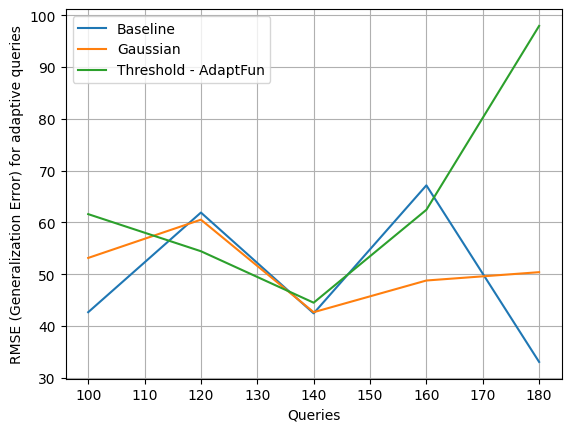

In [25]:

""" plot the generalization error """
plt.figure()
plot_error(stepped_query_num, baseline_generalization_error_list, "Baseline")
plot_error(stepped_query_num, gaussian_generalization_error_list, "Gaussian")
plot_error(stepped_query_num, threshold_generalization_error_list, "Threshold - AdaptFun")
plt.show()

# Evaluate the O(n) adaptivity

In [74]:
max_query_num = 10
max_rounds = 20
stepped_rounds = range(math.floor(max_rounds/2), max_rounds, 10)

In [75]:
''' eval the empirical model as baseline'''
baselin_history_list, baseline_predict_list, baseline_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds)
print(baseline_generalization_error_list)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 7.5778 - mae: 8.0772 - lr: 1.0000e-08
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 7.5762 - mae: 8.0756 - lr: 1.1220e-08
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 7.5730 - mae: 8.0724 - lr: 1.2589e-08
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 7.5680 - mae: 8.0674 - lr: 1.4125e-08
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 7.5613 - mae: 8.0607 - lr: 1.5849e-08
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 7.5527 - mae: 8.0521 - lr: 1.7783e-08
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 7.5422 - mae: 8.0415 - lr: 1.9953e-08
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 7.5294 - mae: 8.0288 - lr: 2.2387e-08
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 7.5144 - mae: 8.0138 - lr: 2.5119e-08
Epoch 10/10
32/32 [==================

In [ ]:
''' Compile and fit the gaussian model'''
gaussian_history_list, gaussian_predict_list, gaussian_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.GAUSSIAN, sigma = 0.03))

In [81]:
print(gaussian_generalization_error_list)

[11.296159]


In [ ]:

''' Compile and fit the threshold out model'''
threshold_history_list, threshold_predict_list, threshold_generalization_error_list = eval_multiple_rounds(max_query_num, stepped_rounds, mechanism = Mechanism(Mechanism.MechanismType.THRESHOLD, sigma = 0.1, hold_frac = 0.4, threshold = 0.5))
print(threshold_generalization_error_list)

In [ ]:



# threshold_generalization_error_list = [15.81994, 19.699022, 23.081583, 25.196918, 26.020424]

""" plot the generalization error """
plt.figure()
plot_error(stepped_query_num, baseline_generalization_error_list, "Baseline")
plot_error(stepped_query_num, gaussian_generalization_error_list, "Gaussian")
plot_error(stepped_query_num, threshold_generalization_error_list, "Threshold - AdaptFun")
plt.show()